Adapted from https://www.kaggle.com/code/taylorsamarel/change-python-version-on-kaggle-taylor-amarel

In [1]:
! pip install setuptools==58.2.0
! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
! pip install ftfy regex tqdm matplotlib jupyter ipykernel opencv-python scikit-image kornia==0.6.7 face-alignment==1.3.5 dlib==19.22.1 git+https://github.com/openai/CLIP.git Ninja gdown
! git clone https://github.com/wty-ustc/HairCLIPv2.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.1/946.1 kB 4.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
google-api-core 1.34.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 3.19.4 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.11.0 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distribut

In [2]:
!pip --version

pip 22.1.2 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)


In [3]:
import gdown

files = [
    "https://drive.google.com/file/d/1g8S81ZybmrF86OjvjLYJzx-wx83ZOiIw/view?usp=drive_link",
    "https://drive.google.com/file/d/1OG6t7q4PpHOoYNdP-ipoxuqYbfMSgPta/view?usp=drive_link",
    "https://drive.google.com/file/d/1c-SgUUQj0X1mIl-W-_2sMboI2QS7GzfK/view?usp=drive_link",
    "https://drive.google.com/file/d/1sa732uBfX1739MFsvtRCKWCN54zYyltC/view?usp=drive_link",
    "https://drive.google.com/file/d/1qk0ZIfA1VmrFUzDJ0g8mK8nx0WtF-5sY/view?usp=drive_link"
]

filenames = [
    "ffhq.pt",
    "seg.pth",
    "shape_predictor_68_face_landmarks.dat",
    "bald_proxy.pt",
    "sketch_proxy.pt"
]

for url, filename in zip(files, filenames):
  gdown.download(url, fuzzy=True, output=f"HairCLIPv2/pretrained_models/{filename}")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1g8S81ZybmrF86OjvjLYJzx-wx83ZOiIw
From (redirected): https://drive.google.com/uc?id=1g8S81ZybmrF86OjvjLYJzx-wx83ZOiIw&confirm=t&uuid=5f63a0c6-e3f8-4420-9fb7-5cdaa47c6948
To: /kaggle/working/HairCLIPv2/pretrained_models/ffhq.pt
100%|██████████| 133M/133M [00:02<00:00, 65.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1OG6t7q4PpHOoYNdP-ipoxuqYbfMSgPta
To: /kaggle/working/HairCLIPv2/pretrained_models/seg.pth
100%|██████████| 53.3M/53.3M [00:00<00:00, 137MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1c-SgUUQj0X1mIl-W-_2sMboI2QS7GzfK
To: /kaggle/working/HairCLIPv2/pretrained_models/shape_predictor_68_face_landmarks.dat
100%|██████████| 99.7M/99.7M [00:01<00:00, 70.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sa732uBfX1739MFsvtRCKWCN54zYyltC
To: /kaggle/working/HairCLIPv2/pretrained_models/bald_proxy.pt
100%|██████████| 8.41M/8.41M [00:00<00:00, 23.8MB/s]
Downloading...
From (uriginal): ht

In [4]:
%cd HairCLIPv2

/kaggle/working/HairCLIPv2


In [5]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import torch
import numpy as np
import tempfile
from PIL import Image
from torchvision import transforms
from scripts.Embedding import Embedding
from scripts.text_proxy import TextProxy
from scripts.ref_proxy import RefProxy
from scripts.sketch_proxy import SketchProxy
from scripts.bald_proxy import BaldProxy
from scripts.color_proxy import ColorProxy
from scripts.feature_blending import hairstyle_feature_blending
from utils.seg_utils import vis_seg
from utils.mask_ui import painting_mask
from utils.image_utils import display_image_list, process_display_input
from utils.model_utils import load_base_models
from utils.options import Options

In [8]:
!wget https://i.pinimg.com/originals/86/13/35/861335aab986171fcb4e2262b67ad9f2.jpg -O /kaggle/working/HairCLIPv2/test_images/unaligned_img/buzzcut.jpg
!wget "https://media.licdn.com/dms/image/D5603AQEsn11UGRSyrw/profile-displayphoto-shrink_800_800/0/1686765030916?e=2147483647&v=beta&t=hwKI-Pen8r8zQ1IbB7g8e_syeYY2OvMizWEM1iqQcmQ" -O /kaggle/working/HairCLIPv2/test_images/unaligned_img/person.jpg

--2024-01-03 17:21:43--  https://i.pinimg.com/originals/86/13/35/861335aab986171fcb4e2262b67ad9f2.jpg
Resolving i.pinimg.com (i.pinimg.com)... 172.64.149.192, 104.18.38.64, 2a04:4e42:84::84
Connecting to i.pinimg.com (i.pinimg.com)|172.64.149.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178511 (174K) [image/jpeg]
Saving to: ‘/kaggle/working/HairCLIPv2/test_images/unaligned_img/buzzcut.jpg’

/kaggle/working/Hai 100%[===================>] 174.33K  --.-KB/s    in 0.04s   

2024-01-03 17:21:44 (4.73 MB/s) - ‘/kaggle/working/HairCLIPv2/test_images/unaligned_img/buzzcut.jpg’ saved [178511/178511]

--2024-01-03 17:21:45--  https://media.licdn.com/dms/image/D5603AQEsn11UGRSyrw/profile-displayphoto-shrink_800_800/0/1686765030916?e=2147483647&v=beta&t=hwKI-Pen8r8zQ1IbB7g8e_syeYY2OvMizWEM1iqQcmQ
Resolving media.licdn.com (media.licdn.com)... 152.199.24.163, 2606:2800:21f:fedd:8b7a:88ab:fc7e:fa3b
Connecting to media.licdn.com (media.licdn.com)|152.199.24.163|:443..

In [48]:
import numpy as np
import PIL
import PIL.Image
import scipy
import scipy.ndimage
from scipy.ndimage import correlate
import dlib
from pathlib import Path
from matplotlib.pyplot import imshow


"""
brief: face alignment with FFHQ method (https://github.com/NVlabs/ffhq-dataset)
author: lzhbrian (https://lzhbrian.me)
date: 2020.1.5
note: code is heavily borrowed from
    https://github.com/NVlabs/ffhq-dataset
    http://dlib.net/face_landmark_detection.py.html

requirements:
    apt install cmake
    conda install Pillow numpy scipy
    pip install dlib
    # download face landmark model from:
    # http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
"""

from PIL import Image
import numpy as np
from scipy.ndimage import correlate
import cv2
from matplotlib import pyplot as plt

def find_bounding_box(large_image, small_image, threshold):
    large_image = np.array(large_image)
    small_image = np.array(small_image)
    
    fig = plt.figure(figsize=(10, 7)) 
    fig.add_subplot(2, 1, 1) 
    
    plt.imshow(large_image)
    plt.title("Large")
    
    fig.add_subplot(2, 1, 2)
    
    plt.imshow(small_image)
    plt.title("Small")

    # Use template matching to find the location of the small image within the large image
    res = cv2.matchTemplate(large_image, small_image, cv2.TM_CCOEFF_NORMED)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(res)
    print("Found in location: ", minVal, maxVal, minLoc, maxLoc)
    
    (top, left) = maxLoc
    
    # Get the bottom right corner of the bounding box
    bottom = top + small_image.shape[1]
    right = left + small_image.shape[0]
    
    print("Making the shape, based on the small image: ", small_image.shape[0], small_image.shape[1])
    
    # Return the bounding box
    return top, left, bottom, right

def get_landmark(filepath,predictor):
    """get landmark with dlib
    :return: np.array shape=(68, 2)
    """
    detector = dlib.get_frontal_face_detector()

    img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)
    filepath = Path(filepath)
    print(f"{filepath.name}: Number of faces detected: {len(dets)}")
    shapes = [predictor(img, d) for k, d in enumerate(dets)]

    lms = [np.array([[tt.x, tt.y] for tt in shape.parts()]) for shape in shapes]

    return lms


def align_face(filepath,predictor):
    """
    :param filepath: str
    :return: list of PIL Images
    """

    lms = get_landmark(filepath,predictor)
    imgs = []
    bounding_coords = []
    for lm in lms:
        lm_chin = lm[0: 17]  # left-right
        lm_eyebrow_left = lm[17: 22]  # left-right
        lm_eyebrow_right = lm[22: 27]  # left-right
        lm_nose = lm[27: 31]  # top-down
        lm_nostrils = lm[31: 36]  # top-down
        lm_eye_left = lm[36: 42]  # left-clockwise
        lm_eye_right = lm[42: 48]  # left-clockwise
        lm_mouth_outer = lm[48: 60]  # left-clockwise
        lm_mouth_inner = lm[60: 68]  # left-clockwise

        # Calculate auxiliary vectors.
        eye_left = np.mean(lm_eye_left, axis=0)
        eye_right = np.mean(lm_eye_right, axis=0)
        eye_avg = (eye_left + eye_right) * 0.5
        eye_to_eye = eye_right - eye_left
        mouth_left = lm_mouth_outer[0]
        mouth_right = lm_mouth_outer[6]
        mouth_avg = (mouth_left + mouth_right) * 0.5
        eye_to_mouth = mouth_avg - eye_avg

        # Choose oriented crop rectangle.
        x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = np.flipud(x) * [-1, 1]
        c = eye_avg + eye_to_mouth * 0.1
        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        qsize = np.hypot(*x) * 2

        # read image
        img = PIL.Image.open(filepath)
        original_img = img

        output_size = 1024
        # output_size = 256
        transform_size = 4096
        enable_padding = True

        # Shrink.
        shrink = int(np.floor(qsize / output_size * 0.5))
        if shrink > 1:
            rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
            img = img.resize(rsize, PIL.Image.ANTIALIAS)
            quad /= shrink
            qsize /= shrink

        # Crop.
        border = max(int(np.rint(qsize * 0.1)), 3)
        crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
                int(np.ceil(max(quad[:, 1]))))
        crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
                min(crop[3] + border, img.size[1]))
        if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
            img = img.crop(crop)
            quad -= crop[0:2]

        # Pad.
        pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
               int(np.ceil(max(quad[:, 1]))))
        pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
               max(pad[3] - img.size[1] + border, 0))
        if enable_padding and max(pad) > border - 4:
            pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
            img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
            h, w, _ = img.shape
            y, x, _ = np.ogrid[:h, :w, :1]
            mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
                              1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
            blur = qsize * 0.02
            img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
            img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
            img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
            quad += pad[:2]


        generated_bounding_coords = find_bounding_box(original_img, img, 0.9)
        print(generated_bounding_coords)
        print(np.asarray(original_img.crop(generated_bounding_coords)).shape, np.asarray(img).shape)
        
        display_image_list([np.asarray(original_img.crop(generated_bounding_coords)), np.asarray(img)])
        
        # Transform.
        img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(),
                            PIL.Image.BILINEAR)
        if output_size < transform_size:
            img = img.resize((output_size, output_size), PIL.Image.LANCZOS)
                
        
        # Save aligned image.
        imgs.append(img)
        bounding_coords.append(generated_bounding_coords)
    return imgs[0], bounding_coords[0]

buzzcut.jpg: Number of faces detected: 1
Found in location:  0.008310604840517044 0.9999998211860657 (183, 658) (0, 35)
Making the shape, based on the small image:  1139 1095
(0, 35, 1095, 1174)
(1139, 1095, 3) (1139, 1095, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: QUAD is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.QUAD instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:175: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:177: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


([<PIL.Image.Image image mode=RGB size=1024x1024>], [])

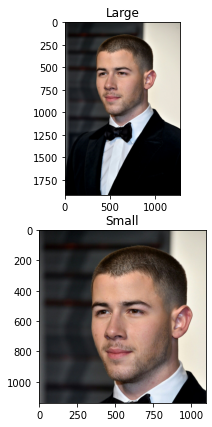

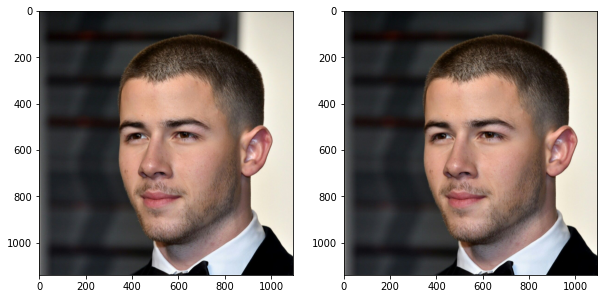

In [36]:
predictor = dlib.shape_predictor("pretrained_models/shape_predictor_68_face_landmarks.dat")
align_face("/kaggle/working/HairCLIPv2/test_images/unaligned_img/buzzcut.jpg", predictor)

In [58]:
def process_image(src_filepath):
    opts = Options().parse(jupyter=True)
    src_name = 'person'# source image name you want to edit

    image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    g_ema, mean_latent_code, seg = load_base_models(opts)
    ii2s = Embedding(opts, g_ema, mean_latent_code[0,0])
    
    # TODO: crop out the file and get the right image
    try:
        aligned_image, bounding_coords = align_face(src_filepath, predictor)
    except:
        return "Face not found."
    
    print("Received aligned images and bounding coords: ", aligned_image, bounding_coords)
    
    dirpath = tempfile.mkdtemp()
    src_latent_filepath = os.path.join(dirpath, "src.npz")
    aligned_image_filepath = os.path.join(dirpath, "image.jpg")
    aligned_image.save(aligned_image_filepath)
    

    if not os.path.isfile(src_latent_filepath):
        inverted_latent_w_plus, inverted_latent_F = ii2s.invert_image_in_FS(image_path=aligned_image_filepath)
        save_latent_path = src_latent_filepath
        np.savez(save_latent_path, latent_in=inverted_latent_w_plus.detach().cpu().numpy(),
                    latent_F=inverted_latent_F.detach().cpu().numpy())
    src_latent = torch.from_numpy(np.load(src_latent_filepath)['latent_in']).cuda()
    src_feature = torch.from_numpy(np.load(src_latent_filepath)['latent_F']).cuda()
    src_image = image_transform(Image.open(aligned_image_filepath).convert('RGB')).unsqueeze(0).cuda()
    input_mask = torch.argmax(seg(src_image)[1], dim=1).long().clone().detach()

    bald_proxy = BaldProxy(g_ema, opts.bald_path)
    text_proxy = TextProxy(opts, g_ema, seg, mean_latent_code)
    ref_proxy = RefProxy(opts, g_ema, seg, ii2s)
    sketch_proxy = SketchProxy(g_ema, mean_latent_code, opts.sketch_path)
    color_proxy = ColorProxy(opts, g_ema, seg)

    edited_hairstyle_img = src_image

    def hairstyle_editing(global_cond=None, local_sketch=False, paint_the_mask=False, \
                          src_latent=src_latent, src_feature=src_feature, input_mask=input_mask, src_image=src_image, \
                            latent_global=None, latent_local=None, latent_bald=None, local_blending_mask=None, painted_mask=None):
        if paint_the_mask:
            modified_mask = painting_mask(input_mask)
            input_mask = torch.from_numpy(modified_mask).unsqueeze(0).cuda().long().clone().detach()
            vis_modified_mask = vis_seg(modified_mask)
            display_image_list([src_image, vis_modified_mask])
            painted_mask = input_mask

        if local_sketch:
            latent_local, local_blending_mask, visual_local_list = sketch_proxy(input_mask)
            display_image_list(visual_local_list)

        if global_cond is not None:
            assert isinstance(global_cond, str)
            latent_bald, visual_bald_list = bald_proxy(src_latent)
            display_image_list(visual_bald_list)

            if global_cond.endswith('.jpg') or global_cond.endswith('.png'):
                latent_global, visual_global_list = ref_proxy(global_cond, src_image, painted_mask=painted_mask)
            else:
                latent_global, visual_global_list = text_proxy(global_cond, src_image, from_mean=True, painted_mask=painted_mask)
            display_image_list(visual_global_list)

        src_feature, edited_hairstyle_img = hairstyle_feature_blending(g_ema, seg, src_latent, src_feature, input_mask, latent_bald=latent_bald,\
                                                    latent_global=latent_global, latent_local=latent_local, local_blending_mask=local_blending_mask)
        return src_feature, edited_hairstyle_img
    
    src_image, edited_image = hairstyle_editing(src_image=src_image, global_cond="buzzcut.jpg")
    
    # replace the edited image within the existing image
    src_image_pil = Image.open(src_filepath)
    src_image_pil.paste(edited_image, (bounding_coords[0], bounding_coords[1]))
    display_image_list([src_image_pil])
    return src_image_pil

In [ ]:
produced_image = process_image("test_images/unaligned_img/person.jpg")
display_image_list([produced_image])

Setting up Perceptual loss...
Loading model from: /kaggle/working/HairCLIPv2/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
person.jpg: Number of faces detected: 1
Found in location:  -0.23755519092082977 1.0 (0, 193) (229, 27)
Making the shape, based on the small image:  419 418
(229, 27, 647, 446)
(419, 418, 3) (419, 418, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: QUAD is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.QUAD instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:175: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:177: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


Received aligned images and bounding coords:  <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7B13A53A07D0> (229, 27, 647, 446)


Embedding: Loss: 0.078, L2 loss: 0.004, Perceptual loss: 0.067, P-norm loss: 0.008:  21%|██        | 53/250 [00:11<00:41,  4.76it/s]   